In [ ]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# additional imports
import pandas as pd
import seaborn as sns
from pandas import read_pickle

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Imbalanced-learn
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [ ]:
df = pd.read_pickle('path/Dataset/New_Preprocessed_Dataset.pkl')

In [3]:
# rename label : none to normal
df['label'] = df['label'].replace('none', 'normal')

In [ ]:
embeddings = np.array(df['embedding'].tolist())
labels = df['label'].tolist() 

### SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(embeddings, labels)

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X_sm, y_sm, test_size=0.3, random_state=42, stratify=y_sm
)

In [6]:
print("Distribution after SMOTE :", dict(zip(*np.unique(y_train_sm, return_counts=True))))

Distribution after SMOTE : {'normal': 7271, 'racism': 7271, 'sexism': 7270}


### RandomOverSampling

In [7]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(embeddings, labels)

X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(
    X_ros, y_ros, test_size=0.3, random_state=42, stratify=y_sm
)

In [8]:
print("Distribution after ROS :", dict(zip(*np.unique(y_train_ros, return_counts=True))))

Distribution after ROS : {'normal': 7271, 'racism': 7271, 'sexism': 7270}


### GAN

In [ ]:
# dataset coming from after GAN augmentation concatenated with original dataset
df_gan = read_pickle('path/Dataset/GAN_Augmented_DF.pkl')

embeddings_gan = np.array(df_gan['embedding'].tolist()) 
labels_gan = df_gan['label'].tolist() 

X_train_gan, X_test_gan, y_train_gan, y_test_gan = train_test_split(
    embeddings_gan, labels_gan, test_size=0.3, random_state=42, stratify=labels_gan
)

In [19]:
print("Distribution after GAN :", dict(zip(*np.unique(y_train_gan, return_counts=True))))

Distribution after GAN : {'normal': 7271, 'racism': 2425, 'sexism': 5781}


## Random Forest

In [ ]:
def train_rf_with_gridsearch(X_train, y_train, cv=None):
    # parapeters for grid search
    param_grid_rf = {
        'n_estimators': [50],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5]
    }

    rf_classifier = RandomForestClassifier(random_state=42)

    # GridSearchCV
    grid_search_rf = GridSearchCV(
        rf_classifier,
        param_grid=param_grid_rf,
        cv=cv,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )

    # train the model
    grid_search_rf.fit(X_train, y_train)

    return grid_search_rf


In [ ]:
def evaluate_model(grid_search, X_test, y_test, label="Model", cmap="Blues", class_names=["normal", "racism", "sexism"]):

    # Get the best classifier from GridSearchCV
    best_clf = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_clf.predict(X_test)

    # Automatically infer class names if not provided
    if class_names is None:
        class_names = sorted(np.unique(y_test))

    # Compute performance metrics
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    precision = round(precision_score(y_test, y_pred, average='weighted', zero_division=0), 2)
    recall = round(recall_score(y_test, y_pred, average='weighted', zero_division=0), 2)
    f1 = round(f1_score(y_test, y_pred, average='weighted', zero_division=0), 2)

    print(f"\n--- Results for {label} ---")

    # Raw confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=class_names)
    print("Confusion matrix:")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix ({label})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.grid(False)
    plt.show()

    # Percentage confusion matrix
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    cm_percent = np.round(cm_percent, 1)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap=cmap, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix ({label}) - Percentages (%)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.grid(False)
    plt.show()

    # Print classification report
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0, target_names=class_names))

    # Print summary metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("Best parameters found:", grid_search.best_params_)

    return best_clf


Fitting 5 folds for each of 6 candidates, totalling 30 fits

--- Results for RF with SMOTE ---
Confusion matrix:


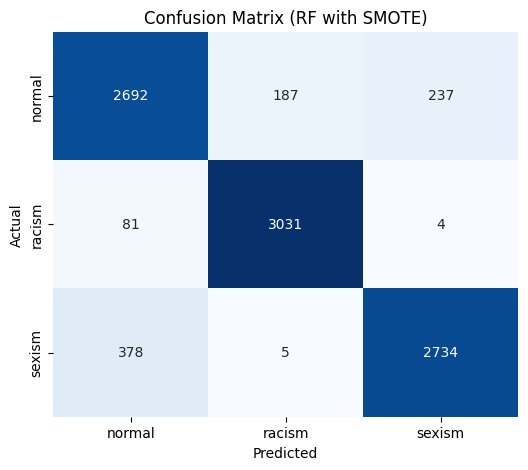

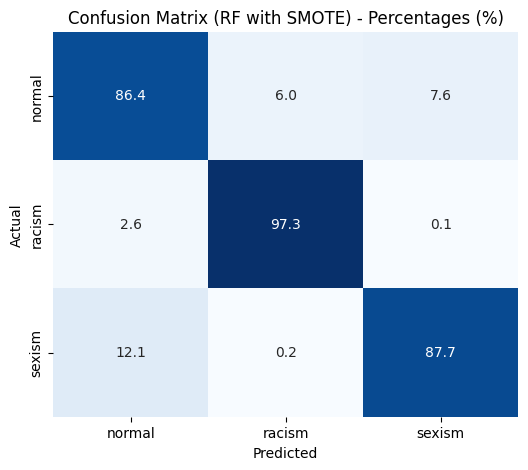


Classification report:
              precision    recall  f1-score   support

      normal       0.85      0.86      0.86      3116
      racism       0.94      0.97      0.96      3116
      sexism       0.92      0.88      0.90      3117

    accuracy                           0.90      9349
   macro avg       0.90      0.90      0.90      9349
weighted avg       0.90      0.90      0.90      9349

Accuracy: 0.9
Precision: 0.9
Recall: 0.9
F1-Score: 0.9
Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


RandomForestClassifier(n_estimators=50, random_state=42)

In [13]:
grid_search_smote = train_rf_with_gridsearch(X_train_sm, y_train_sm)
evaluate_model(grid_search_smote, X_test_sm, y_test_sm, label="RF with SMOTE")

Fitting 5 folds for each of 6 candidates, totalling 30 fits

--- Results for RF with ROS ---
Confusion matrix:


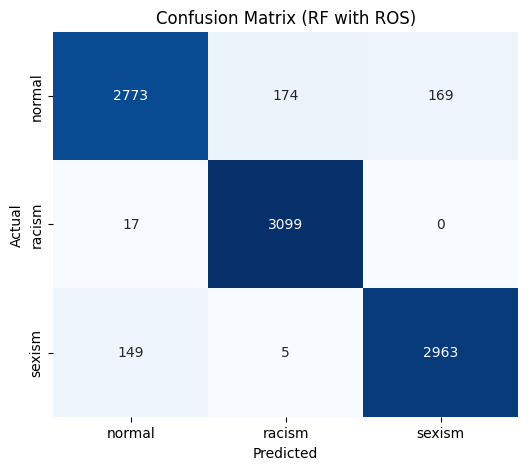

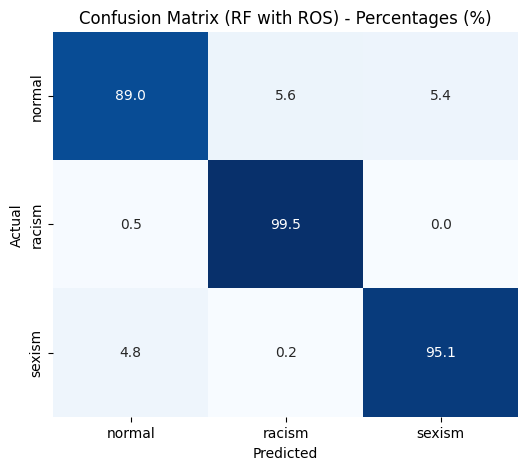


Classification report:
              precision    recall  f1-score   support

      normal       0.94      0.89      0.92      3116
      racism       0.95      0.99      0.97      3116
      sexism       0.95      0.95      0.95      3117

    accuracy                           0.95      9349
   macro avg       0.94      0.95      0.94      9349
weighted avg       0.94      0.95      0.94      9349

Accuracy: 0.95
Precision: 0.94
Recall: 0.95
F1-Score: 0.94
Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


RandomForestClassifier(n_estimators=50, random_state=42)

In [14]:
grid_search_ros = train_rf_with_gridsearch(X_train_ros, y_train_ros)
evaluate_model(grid_search_ros, X_test_ros, y_test_ros, label="RF with ROS")

Fitting 5 folds for each of 6 candidates, totalling 30 fits

--- Results for RF with GAN ---
Confusion matrix:


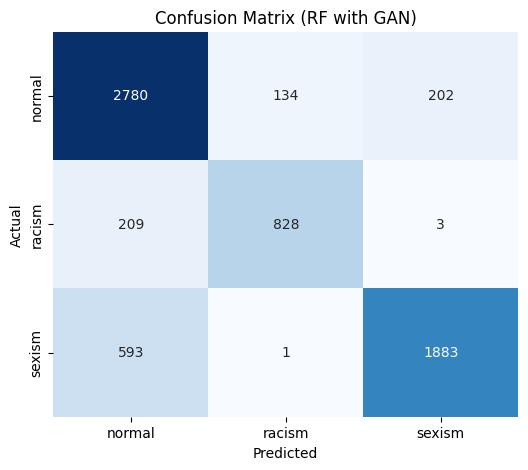

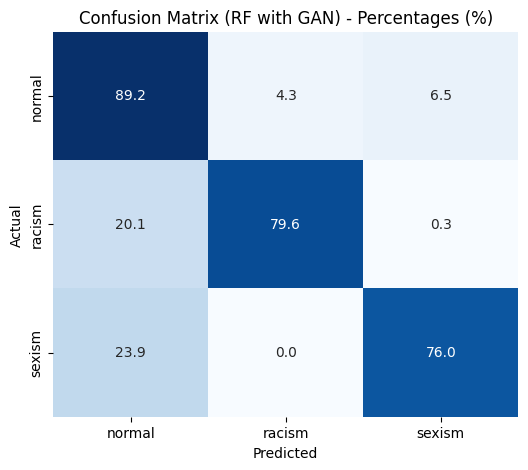


Classification report:
              precision    recall  f1-score   support

      normal       0.78      0.89      0.83      3116
      racism       0.86      0.80      0.83      1040
      sexism       0.90      0.76      0.82      2477

    accuracy                           0.83      6633
   macro avg       0.85      0.82      0.83      6633
weighted avg       0.84      0.83      0.83      6633

Accuracy: 0.83
Precision: 0.84
Recall: 0.83
F1-Score: 0.83
Best parameters found: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}


RandomForestClassifier(min_samples_split=5, n_estimators=50, random_state=42)

In [20]:
grid_search_gan = train_rf_with_gridsearch(X_train_gan, y_train_gan)
evaluate_model(grid_search_gan, X_test_gan, y_test_gan, label="RF with GAN")

### Without augmentation

In [16]:
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(
    embeddings, labels, test_size=0.3, random_state=42, stratify=labels
)

Fitting 5 folds for each of 6 candidates, totalling 30 fits

--- Results for RF without augmentation ---
Confusion matrix:


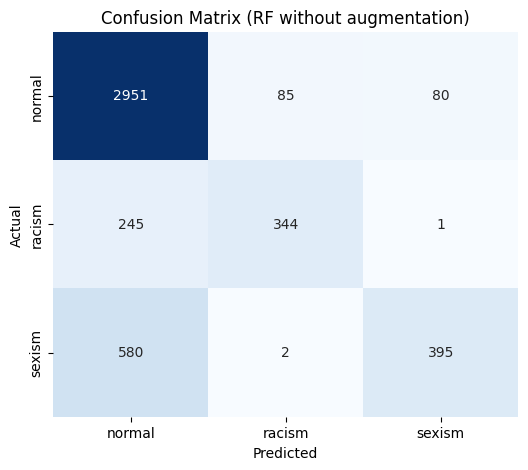

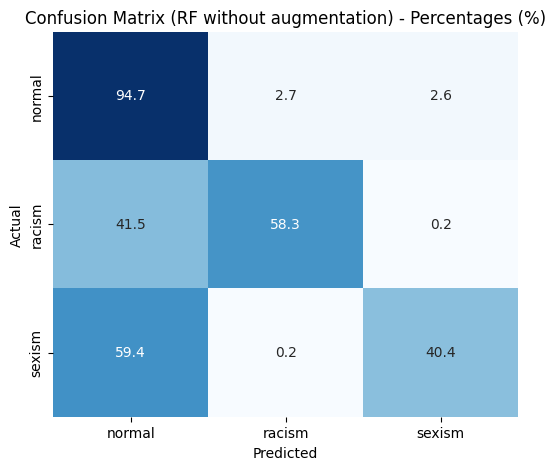


Classification report:
              precision    recall  f1-score   support

      normal       0.78      0.95      0.86      3116
      racism       0.80      0.58      0.67       590
      sexism       0.83      0.40      0.54       977

    accuracy                           0.79      4683
   macro avg       0.80      0.64      0.69      4683
weighted avg       0.79      0.79      0.77      4683

Accuracy: 0.79
Precision: 0.79
Recall: 0.79
F1-Score: 0.77
Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


RandomForestClassifier(n_estimators=50, random_state=42)

In [17]:
grid_search_no = train_rf_with_gridsearch(X_train_no, y_train_no)
evaluate_model(grid_search_no, X_test_no, y_test_no, label="RF without augmentation")